In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

os.chdir('/home/mynasino/kaggle_houseprice/model_final')

In [2]:
MiscVal_train_X = pd.read_csv('data_process/MiscVal_data.csv').drop(['Unnamed: 0'],axis=1).as_matrix()[0:1460]
MiscVal_pridict_X = pd.read_csv('data_process/MiscVal_data.csv').drop(['Unnamed: 0'],axis=1).as_matrix()[1460:2919]

In [3]:
one_hot_df = pd.read_csv('data_process/one_hot_features.csv').drop(['Unnamed: 0'], axis=1)
numerical_df = pd.read_csv('data_process/numerical_with_pridict.csv').drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

df = pd.concat([one_hot_df,numerical_df],axis=1)
df_y = pd.read_csv('/home/mynasino/kaggle_houseprice/data/train.csv')['SalePrice']

train_X = df.as_matrix()[0:1460]
train_y = df_y.as_matrix().reshape([1460,1])
pridict_X = df.as_matrix()[1460:2919]

In [7]:
def Xavier_init(fan_in,fan_out,constant=1):
    low = -constant * np.sqrt(6/(fan_in + fan_out))
    high = constant * np.sqrt(6/(fan_in + fan_out))
    return tf.random_uniform((fan_in,fan_out),minval=low,maxval=high,dtype=tf.float32)

In [8]:
import random

batch_size = 16
num_examples = 1460

def data_iter():
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = np.array(idx[i:min(i + batch_size, num_examples)]) #np.array() missed
        yield np.take(train_X, j, axis=0), np.take(MiscVal_train_X, j).reshape([len(j),1]), np.take(train_y, j).reshape([len(j),1])

In [9]:
in_units = 377
h1_units = 50
h2_units = 8

W1 = tf.Variable(Xavier_init(in_units,h1_units))
b1 = tf.Variable(tf.constant(0.1,shape=[h1_units]))
W2 = tf.Variable(Xavier_init(h1_units,h2_units))
b2 = tf.Variable(tf.constant(0.1,shape=[h2_units]))
W3 = tf.Variable(Xavier_init(h2_units,1))
b3 = tf.Variable(tf.constant(0.1,shape=[1]))

in_X = tf.placeholder(tf.float32,[None,in_units])
Misc_X = tf.placeholder(tf.float32,[None,1])
hidden1 = tf.nn.relu(tf.matmul(in_X,W1) + b1)
hidden2 = tf.nn.relu(tf.matmul(hidden1,W2) + b2)
y = tf.nn.relu(tf.matmul(hidden2,W3) + b3) + Misc_X

y_ = tf.placeholder(tf.float32,[None,1])
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.log(y + 1) - tf.log(y_ + 1))))
loss_with_L2 = loss + 0.1 * tf.reduce_mean(tf.square(W1))
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss_with_L2)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss = []
test_loss = []

for epoch_i in range(2000):
    for batch_X, MiscVal_batch_X, batch_y in data_iter():
        sess.run(train_step,feed_dict={in_X: batch_X, Misc_X:MiscVal_batch_X, y_: batch_y})
    
    #generate train_examples and test_examples
    train_id = list(range(0, 730))
    test_id = list(range(730,1460))
    arr_train_x = np.take(train_X, train_id, axis=0)
    arr_Misc_train_x = np.take(MiscVal_train_X, train_id).reshape([len(train_id),1])
    arr_train_y = np.take(train_y, train_id).reshape([len(train_id),1])
    arr_test_x = np.take(train_X, test_id, axis=0)
    arr_Misc_test_x = np.take(MiscVal_train_X, test_id).reshape([len(test_id),1])
    arr_test_y = np.take(train_y, test_id).reshape([len(test_id),1])
        
    #calculate train loss
    train_loss.append(sess.run(loss,feed_dict={in_X: arr_train_x, Misc_X:arr_Misc_train_x ,y_: arr_train_y}))
        
    #calculate test loss
    test_loss.append(sess.run(loss,feed_dict={in_X: arr_test_x, Misc_X:arr_Misc_test_x ,y_:arr_test_y}))
        
    print("epoch %d" % epoch_i, "train_loss", train_loss[-1], "test_loss", test_loss[-1])
    
    #add early stop here to impove generalization ability

epoch 0 train_loss 5.42773 test_loss 5.41646
epoch 1 train_loss 4.02322 test_loss 4.00996
epoch 2 train_loss 3.18443 test_loss 3.17021
epoch 3 train_loss 2.59137 test_loss 2.57626
epoch 4 train_loss 2.13372 test_loss 2.11781
epoch 5 train_loss 1.76121 test_loss 1.74433
epoch 6 train_loss 1.44781 test_loss 1.42978
epoch 7 train_loss 1.17959 test_loss 1.16023
epoch 8 train_loss 0.947999 test_loss 0.927088
epoch 9 train_loss 0.750065 test_loss 0.727381
epoch 10 train_loss 0.584813 test_loss 0.560126
epoch 11 train_loss 0.458322 test_loss 0.431949
epoch 12 train_loss 0.3715 test_loss 0.344763
epoch 13 train_loss 0.318886 test_loss 0.293828
epoch 14 train_loss 0.280301 test_loss 0.25881
epoch 15 train_loss 0.252065 test_loss 0.234066
epoch 16 train_loss 0.229015 test_loss 0.21373
epoch 17 train_loss 0.209635 test_loss 0.196783
epoch 18 train_loss 0.195248 test_loss 0.183729
epoch 19 train_loss 0.185309 test_loss 0.174892
epoch 20 train_loss 0.178082 test_loss 0.16835
epoch 21 train_loss 0.1

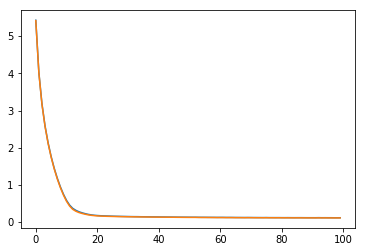

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
s = 0
e = 100

plt.plot(range(s,e),train_loss[s:e],range(s,e),test_loss[s:e])